In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install silence_tensorflow
!pip install pycm
!pip install lime
!pip install transformers
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp37-none-any.whl size=3743 sha256=961795d94b48ac7365f86bb848cb4584be6f0b00338018292139bae361a4acd1
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 573kB 26.7MB/s 
     |████████████████████████████████| 276kB 18.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=02d6cf813f392ecd00ee0be871258a934436fc5270c5f4e308713c3d62fd2efa
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.0MB 19.6MB/s 
     |████████████████████████████████| 890kB 54.3MB/s 
     |████████████████████████████████| 3.2MB 52.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-no

True

In [4]:
import os
default_path = "/content/gdrive/MyDrive/Colab Notebooks/Automatic Software Artifacts"
os.chdir(default_path)

In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, LSTM, SpatialDropout1D, Input, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import nltk
import re
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from pycm import *
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import layers, preprocessing as kprocessing
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
## for bert language model
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB

from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

import utils_functions as uf

import matplotlib as mpl
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "k", "c"]) 

np.random.seed(7)

### Some Utils Functions

In [6]:
# '''
# Compute different text length metrics.
# :parameter
#     :param dtf: dataframe - dtf with a text column
#     :param column: string - name of column containing text
# :return
#     dtf: input dataframe with 2 new columns
# '''
def add_text_length(dtf, column):
    dtf['word_count'] = dtf[column].apply(lambda x: len(str(x).split(" ")))
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(str(x).split(".")))
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf


In [7]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def display_closestwords_tsnescatterplot(word_vect, dim, words):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]
    
    # add the vector for each of the closest words to the array
    close_words=[]
    for word in words:
        arr = np.append(arr, np.array([word_vect[word]]), axis=0)
        close_words +=model.similar_by_word(word)
        
    for wrd_score in close_words:
        wrd_vector = word_vect[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
def tsne_plot(word_vect, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(word_vect[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(14, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### Read and Show a Data Sample

In [8]:
file = 'dataset.csv'
df = pd.read_csv(file,encoding='ISO-8859-1')

labels = df.NumLabel
labels = labels.to_numpy()

In [9]:
df.sample(5)

,Label,NumLabel,Text,FileName
11,Design Document,0,place your ssl tls server keys and certificate...,../MSRDataset/Oracle/Design Document/2521-dock...
128,License,4,mit licenced copyright Ã¢ wisembly permission ...,../MSRDataset/Oracle/License/21787-elephant.io...
158,Contributors' Guide,5,running the tests you ll need npm https npmjs ...,../MSRDataset/Oracle/Contributors' Guide/15685...
98,License,4,the mit license copyright c automattic dev clo...,../MSRDataset/Oracle/License/21443-socket.io-n...
131,Contributors' Guide,5,angular js enterprise edition boilerplate this...,../MSRDataset/Oracle/Contributors' Guide/5371-...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     208 non-null    object
 1   NumLabel  208 non-null    int64 
 2   Text      208 non-null    object
 3   FileName  208 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.6+ KB


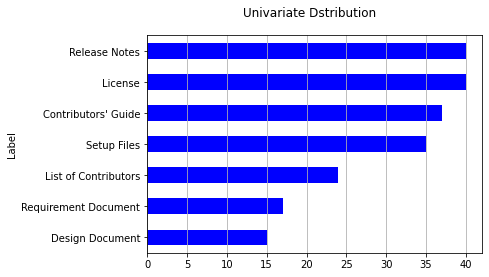

In [10]:
fig, ax = plt.subplots()
fig.suptitle("Univariate Dstribution", fontsize=12)
df["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Run Preprocessing Function to Clean Text

In [15]:
# Load stopwords from NLTK
lst_stopwords = nltk.corpus.stopwords.words("english")
df["text_clean"] = df["Text"].apply(lambda x: 
                      uf.utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
                      lst_stopwords=lst_stopwords))
df.sample(5)

,Label,NumLabel,Text,FileName,text_clean
31,List of Contributors,1,copyrightbegin copyright ericsson ab all right...,../MSRDataset/Oracle/List of Contributors/1544...,copyrightbegin copyright ericsson ab right res...
205,Release Notes,6,fixes fixed status code error on supervisord s...,../MSRDataset/Oracle/Release Notes/7215-dextr-...,fix fix statu code error supervisord superviso...
60,Setup Files,2,name device js version homepage https github c...,../MSRDataset/Oracle/Setup Files/23829-device....,name devic j version homepag http github com m...
30,List of Contributors,1,original authors niclas eklund contributors,../MSRDataset/Oracle/List of Contributors/1544...,origin author nicla eklund contributor
6,Design Document,0,mechanize forms span class docwarning this doc...,../MSRDataset/Oracle/Design Document/1641-mech...,mechan form span class docwarn document need r...


### Text Length Analysis

In [ ]:
dtf = add_text_length(df, "text_clean")
dtf.head()

                      min         mean            max
word_count            3.0  1186.144231   40837.000000
char_count           16.0  5896.274038  206636.000000
sentence_count        1.0     1.000000       1.000000
avg_word_length       3.5     5.384789       7.153846
avg_sentence_lenght   3.0  1186.144231   40837.000000


,Label,NumLabel,Text,FileName,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,Design Document,0,design operation and maintenance manual for me...,../MSRDataset/Oracle/Design Document/13663-cmg...,design oper mainten manual messagelogg message...,2485,14533,1,5.848290,2485.0
1,Design Document,0,gspread documentation master file created by s...,../MSRDataset/Oracle/Design Document/30200-gsp...,gspread document master file creat sphinx quic...,133,899,1,6.759398,133.0
2,Design Document,0,non blocking trace setting introduction before...,../MSRDataset/Oracle/Design Document/15549-otp...,non block trace set introduct otp trace set ch...,772,4302,1,5.572539,772.0
3,Design Document,0,layout doc title delite popup delite popup del...,../MSRDataset/Oracle/Design Document/12383-del...,layout doc titl delit popup delit popup delit ...,983,5086,1,5.173957,983.0
4,Design Document,0,design patterns observer,../MSRDataset/Oracle/Design Document/55544-des...,design pattern observ,3,19,1,6.333333,3.0


### Feature Engineering - Tf-Idf (advanced variant of BoW)

In [ ]:
# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

### Create the feature matrix

In [ ]:
corpus = df["text_clean"]
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

# sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1,
#             cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
# The position of a certain word (example)
word = "java"
dic_vocabulary[word]

4459

### Feature Selection
In order to drop some columns and reduce the matrix dimensionality:
  1. Treat each category as binary (for example, the “Design Document” category is 1 and 0 for the others);  
  2. Perform a Chi-Square test to determine whether a feature and the (binary) target are independent;  
  3. keep only the features with a certain p-value from the Chi-Square test.

In [ ]:
y = df["Label"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.90
df_features = pd.DataFrame()
print("Initial dimension", len(X_names))
# perform a Chi-Square test to determine whether a feature and the (binary) target are independent
# keep only the features with a certain p-value from the Chi-Square test.
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "Label":cat}))
    df_features = df_features.sort_values(["Label","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()
print("Final dimension", len(X_names))

Initial dimension 10000
Final dimension 354


### Selected Features Sample

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(df_features[df_features["Label"]==cat]))
   print("  . top features:", ",".join(
df_features[df_features["Label"]==cat]["feature"].values[:10]))
   print(" ")

# Contributors' Guide:
  . selected features: 25
  . top features: pull request,pull,request,test,issu,mechan,selenium,plea,fork,cla
 
# Design Document:
  . selected features: 47
  . top features: design pattern,counter,messageloggerq,messageloggerscrib,item,breakpoint,observ,autoexcept,pattern,messagesend
 
# License:
  . selected features: 174
  . top features: softwar,licens,copyright,copi,warranti,shall,distribut,notic,permiss,deal softwar
 
# List of Contributors:
  . selected features: 39
  . top features: martin,origin author,driver,com,gmail,gmail com,net,de,maintain,chri
 
# Release Notes:
  . selected features: 19
  . top features: fix,ad,gitx,updat,view,commit view,add,chang,chang ad,johann
 
# Requirement Document:
  . selected features: 28
  . top features: mount,marker,block,speakup,uml,column,world,codec,filesystem,audio
 
# Setup Files:
  . selected features: 22
  . top features: grunt,docker,mock,url http,person cz,grunt contrib,cz,contrib,mock person,nova
 


### Refit and Reduce Dimensionality

Text(0.5, 1.0, 'Sparse Matrix Sample')

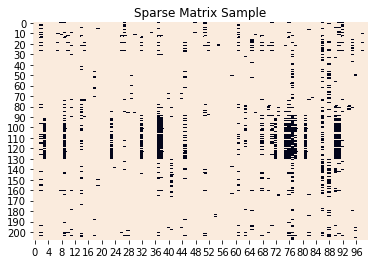

In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0,
            vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

### Train and Test a Model

In [ ]:
# Model Design
clf1 = svm.SVC(gamma='scale')
clf2 = RandomForestClassifier(n_estimators=500, random_state=1)
clf3 = MultinomialNB(alpha=0.01)
clf4 = DecisionTreeClassifier(random_state=0, max_depth=500)

svc = SVC(probability=True, kernel='linear')
ada = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)
ada2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")
ada3 = AdaBoostClassifier()
rf = RandomForestClassifier(max_depth=100, n_estimators=100, max_features=10)
# nb = naive_bayes.MultinomialNB(alpha=0.01)
nb = naive_bayes.MultinomialNB(alpha=0.0)
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', class_weight='balanced', C=1500)
dt = DecisionTreeClassifier(max_depth=500)

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):
  accrs = []
  fold=0
  k = 10
  sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)
  for train_index, test_index in sss.split(X, df["Label"].values):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = df.Label[train_index], df.Label[test_index]

      fold += 1

      # train classifier
      model = dt.fit(X_train, y_train)
      predicted = model.predict(X_test)
      predicted_prob = model.predict_proba(X_test)
      accr = metrics.accuracy_score(y_test, predicted)
      
      conf_matrix = confusion_matrix(y_test, predicted)
      conf_matrix_list_of_arrays .append(conf_matrix)
      
      accrs.append(accr)

      print('\n--------------------------------------------------------------------')
      print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
      print('\n--------------------------------------------------------------------')
  final_mean.append(sum(accrs)/k)
    
# print("Mean Accuracy:", sum(accrs)/k)
# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)


--------------------------------------------------------------------
Iteração: 1 Fold: 1 Accuracy: 0.5714285714285714, Mean Accuracy: 0.5714285714285714

--------------------------------------------------------------------

--------------------------------------------------------------------
Iteração: 1 Fold: 2 Accuracy: 0.7380952380952381, Mean Accuracy: 0.6547619047619048

--------------------------------------------------------------------

--------------------------------------------------------------------
Iteração: 1 Fold: 3 Accuracy: 0.6904761904761905, Mean Accuracy: 0.6666666666666666

--------------------------------------------------------------------

--------------------------------------------------------------------
Iteração: 1 Fold: 4 Accuracy: 0.6190476190476191, Mean Accuracy: 0.6547619047619048

--------------------------------------------------------------------

--------------------------------------------------------------------
Iteração: 1 Fold: 5 Accuracy: 0.76

In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.661904761904762


### Evaluate

#### Plot metrics resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       1.0	       0.5	      0.67	       0.7	      0.75
List of Contributors	       1.0	       0.4	      0.57	      0.61	       0.7
Setup Files         	      0.56	      0.83	      0.67	      0.61	      0.86
Requirement Document	       0.5	      0.33	       0.4	      0.37	      0.65
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	      0.57	      0.57	      0.57	      0.48	      0.74
Release Notes       	       0.6	      0.75	      0.67	      0.57	      0.81

Micro Average       	      0.69	      0.69	      0.69	      0.61	      0.81
Macro Average       	      0.75	      0.63	      0.65	      0.62	      0.79


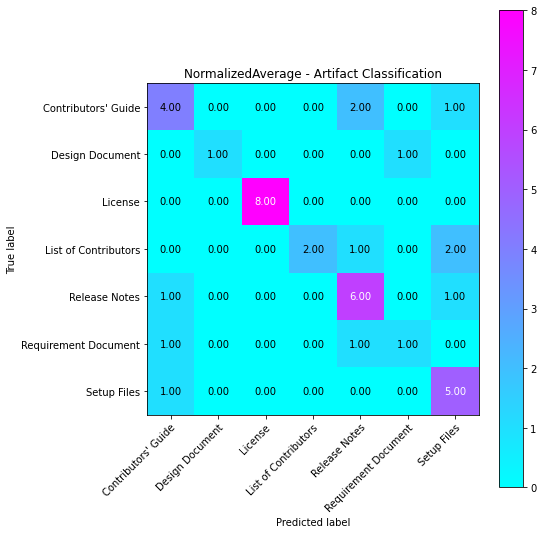

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## SO-Word2Vec

### Loading the model (SO-Word2Vec)
A word2vec model trained on Stack Overflow posts

In [11]:
from gensim.models.keyedvectors import KeyedVectors

word_vect = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)
vocab_obj = word_vect.vocab["word"]
vocab_obj.count

1786558

In [12]:
# Verifica se a palavra "upload" faz parte do vocábulo
'upload' in word_vect.vocab # Check if "upload" is in w2v vacabulary

True

### A Word and its Context (3D)

# word_vect.most_similar(word, topn=20)

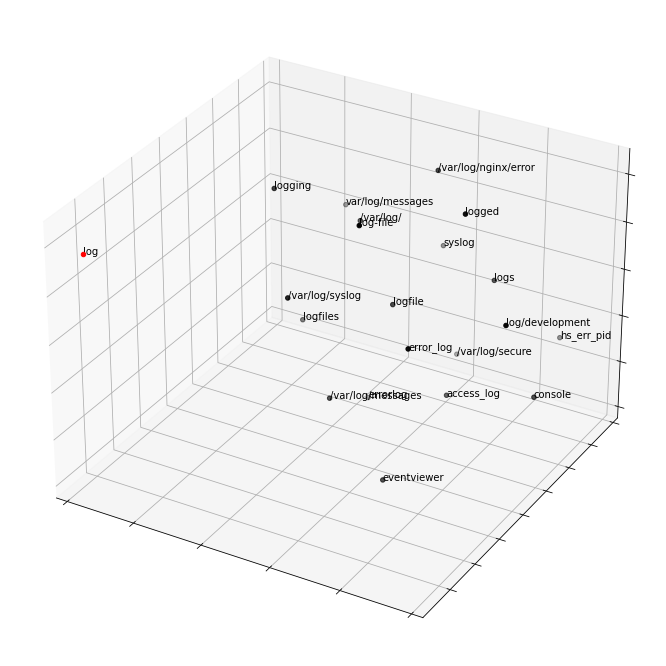

In [ ]:
word = "log"
fig = plt.figure(figsize=(15,12))
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 word_vect.most_similar(word, topn=20)]
X = word_vect[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dataframe
dt_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dt_["input"] = 0
dt_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dt_[dt_["input"]==0]['x'], 
           dt_[dt_["input"]==0]['y'], 
           dt_[dt_["input"]==0]['z'], c="black")
ax.scatter(dt_[dt_["input"]==1]['x'], 
           dt_[dt_["input"]==1]['y'], 
           dt_[dt_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dt_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

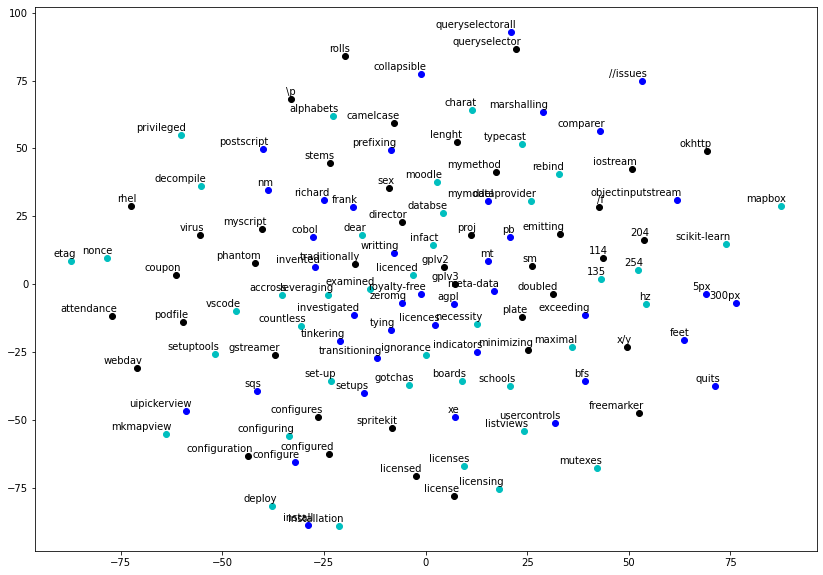

In [ ]:
#display_closestwords_tsnescatterplot(model, 100, ['man', 'dog'])
words=list(word_vect.vocab.keys())
word1 = words[10000:10100]
words2= word_vect.similar_by_word('licence')
words3= word_vect.similar_by_word('setup')
words= word1 + [w[0] for w in words2] + [w[0] for w in words3]
#print(words)
tsne_plot(word_vect, words)

### Feature Engineering

### Transform the Corpus into Padded Squences

In [16]:
corpus = df["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [17]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

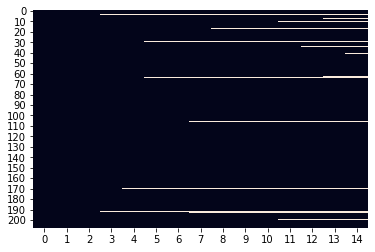

In [ ]:
sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Create the Matrix of Embedding

In [18]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 200))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  word_vect[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [19]:
#It can be navigated by word id, which can be obtained from the vocabulary.
word = "script"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 268 |idx
embeddings[idx]: (200,) |vector


In [20]:
# Coverage
nonzero_elements = np.count_nonzero(np.count_nonzero(embeddings, axis=1))
nonzero_elements / embeddings.shape[0]

0.6166322618696549

### Deep Learning Model

In [105]:
from tensorflow.keras.constraints import max_norm
def fit_bert_classif(X_train, y_train, X_test, encode_y=False, dic_y_mapping=None, model=None, epochs=1, batch_size=16):
    ## encode y
    if encode_y is True:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
    # print(dic_y_mapping)
    
    ## model
    if model is None:
        # input
        x_in = layers.Input(shape=(X_train.shape[1],))

        # embedding
        X = layers.Embedding(input_dim=embeddings.shape[0],  
                              output_dim=embeddings.shape[1], 
                              weights=[embeddings],
                              input_length=X_train.shape[1], trainable=True)(x_in) 
        
        # 2 layers of bidirectional lstm
        X = layers.Bidirectional(layers.LSTM(180, return_sequences=True))(X)
        X = layers.Bidirectional(layers.LSTM(90))(X)
        X = layers.Dropout(0.3)(X)

        # ## final dense layers
        # X = layers.Dense(20, activation='tanh', kernel_constraint=max_norm(11))(X)
        # X = layers.Dense(512, activation='relu')(X)

        y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(X)

        ## compile
        model = Model(x_in, y_out)
        opt = Adam(learning_rate=0.1)
        model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
        # print(model.summary())
        
    ## train
    verbose = 1 if epochs > 1 else 2
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.2)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = model.predict(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob] if encode_y is True else [np.argmax(pred)]
    return training.model, predicted_prob, predicted

'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

### Define Target

In [22]:
y = df["Label"].values

### Train the Model

Epoch 1/5
17/17 [==============================] - 6s 103ms/step - loss: 1.8255 - accuracy: 0.2946 - val_loss: 1.4567 - val_accuracy: 0.4118
Epoch 2/5
17/17 [==============================] - 1s 36ms/step - loss: 0.8078 - accuracy: 0.8138 - val_loss: 1.1613 - val_accuracy: 0.4706
Epoch 3/5
17/17 [==============================] - 1s 36ms/step - loss: 0.3566 - accuracy: 0.9441 - val_loss: 1.2715 - val_accuracy: 0.5588
Epoch 4/5
17/17 [==============================] - 1s 35ms/step - loss: 0.0707 - accuracy: 1.0000 - val_loss: 1.1690 - val_accuracy: 0.6176
Epoch 5/5
17/17 [==============================] - 1s 35ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 1.2922 - val_accuracy: 0.6471


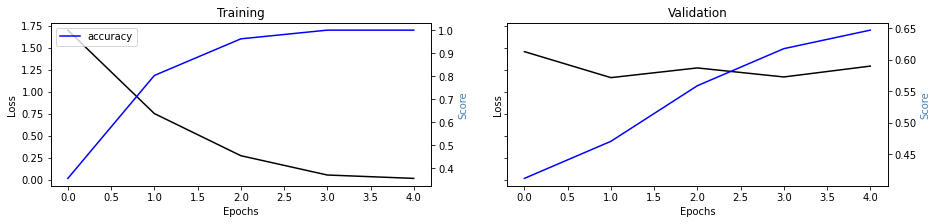


--------------------------------------------------------------------
Iteração: 1 Fold: 1 Accuracy: 0.6904761904761905, Mean Accuracy: 0.6904761904761905

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 101ms/step - loss: 1.7248 - accuracy: 0.4056 - val_loss: 1.3368 - val_accuracy: 0.5882
Epoch 2/5
17/17 [==============================] - 1s 35ms/step - loss: 0.7391 - accuracy: 0.8117 - val_loss: 0.8284 - val_accuracy: 0.6471
Epoch 3/5
17/17 [==============================] - 1s 35ms/step - loss: 0.1971 - accuracy: 0.9920 - val_loss: 0.8871 - val_accuracy: 0.6471
Epoch 4/5
17/17 [==============================] - 1s 35ms/step - loss: 0.0460 - accuracy: 0.9978 - val_loss: 0.9476 - val_accuracy: 0.7059
Epoch 5/5
17/17 [==============================] - 1s 36ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.9554 - val_accuracy: 0.6765


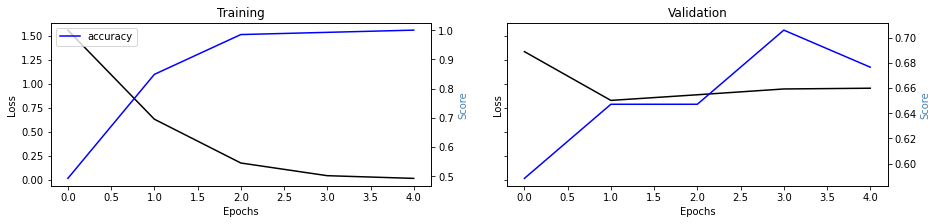


--------------------------------------------------------------------
Iteração: 1 Fold: 2 Accuracy: 0.6190476190476191, Mean Accuracy: 0.6547619047619048

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 8s 104ms/step - loss: 1.7960 - accuracy: 0.2988 - val_loss: 1.4346 - val_accuracy: 0.5294
Epoch 2/5
17/17 [==============================] - 1s 34ms/step - loss: 0.8941 - accuracy: 0.7473 - val_loss: 1.2065 - val_accuracy: 0.6176
Epoch 3/5
17/17 [==============================] - 1s 35ms/step - loss: 0.2444 - accuracy: 0.9775 - val_loss: 1.1556 - val_accuracy: 0.6471
Epoch 4/5
17/17 [==============================] - 1s 34ms/step - loss: 0.0596 - accuracy: 0.9861 - val_loss: 1.4509 - val_accuracy: 0.5294
Epoch 5/5
17/17 [==============================] - 1s 35ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 1.4370 - val_accuracy: 0.6176


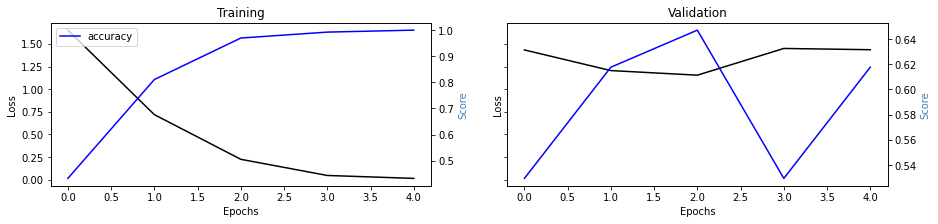


--------------------------------------------------------------------
Iteração: 1 Fold: 3 Accuracy: 0.7142857142857143, Mean Accuracy: 0.6746031746031745

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 106ms/step - loss: 1.7607 - accuracy: 0.2681 - val_loss: 1.3212 - val_accuracy: 0.5588
Epoch 2/5
17/17 [==============================] - 1s 35ms/step - loss: 0.8138 - accuracy: 0.8518 - val_loss: 1.0234 - val_accuracy: 0.6471
Epoch 3/5
17/17 [==============================] - 1s 36ms/step - loss: 0.2216 - accuracy: 0.9868 - val_loss: 1.1206 - val_accuracy: 0.5882
Epoch 4/5
17/17 [==============================] - 1s 36ms/step - loss: 0.0425 - accuracy: 1.0000 - val_loss: 1.2758 - val_accuracy: 0.6471
Epoch 5/5
17/17 [==============================] - 1s 36ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 1.4253 - val_accuracy: 0.6471


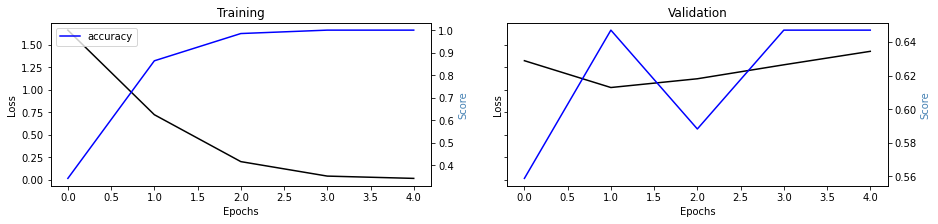


--------------------------------------------------------------------
Iteração: 1 Fold: 4 Accuracy: 0.6904761904761905, Mean Accuracy: 0.6785714285714286

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 105ms/step - loss: 1.7637 - accuracy: 0.2756 - val_loss: 1.3571 - val_accuracy: 0.5588
Epoch 2/5
17/17 [==============================] - 1s 36ms/step - loss: 0.8536 - accuracy: 0.8000 - val_loss: 1.1949 - val_accuracy: 0.5294
Epoch 3/5
17/17 [==============================] - 1s 37ms/step - loss: 0.2963 - accuracy: 0.9689 - val_loss: 0.9954 - val_accuracy: 0.6176
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0765 - accuracy: 1.0000 - val_loss: 1.1094 - val_accuracy: 0.5588
Epoch 5/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 1.2191 - val_accuracy: 0.5882


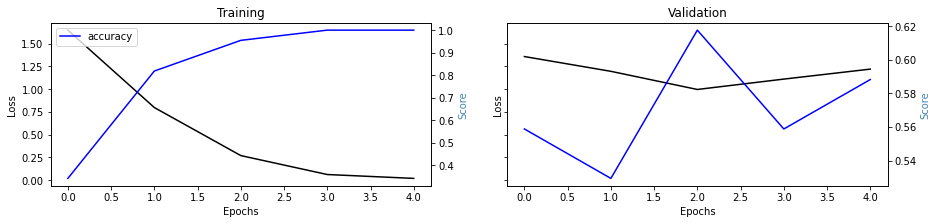


--------------------------------------------------------------------
Iteração: 1 Fold: 5 Accuracy: 0.6904761904761905, Mean Accuracy: 0.680952380952381

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 106ms/step - loss: 1.7438 - accuracy: 0.3602 - val_loss: 1.3405 - val_accuracy: 0.5588
Epoch 2/5
17/17 [==============================] - 1s 37ms/step - loss: 0.7463 - accuracy: 0.8924 - val_loss: 1.2402 - val_accuracy: 0.5882
Epoch 3/5
17/17 [==============================] - 1s 37ms/step - loss: 0.2379 - accuracy: 0.9827 - val_loss: 1.1835 - val_accuracy: 0.7059
Epoch 4/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0750 - accuracy: 0.9983 - val_loss: 1.3915 - val_accuracy: 0.5882
Epoch 5/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 1.6381 - val_accuracy: 0.6176


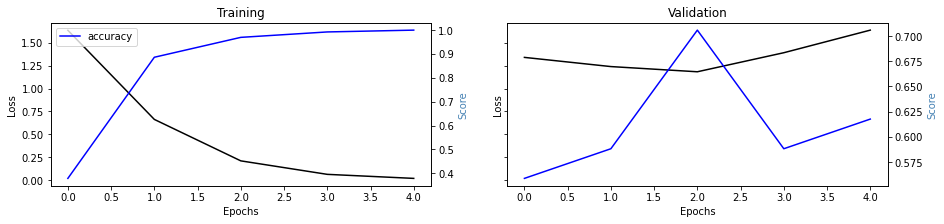


--------------------------------------------------------------------
Iteração: 1 Fold: 6 Accuracy: 0.6190476190476191, Mean Accuracy: 0.6706349206349206

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 8s 222ms/step - loss: 1.8597 - accuracy: 0.1951 - val_loss: 1.3476 - val_accuracy: 0.5294
Epoch 2/5
17/17 [==============================] - 1s 37ms/step - loss: 0.8951 - accuracy: 0.8039 - val_loss: 0.9805 - val_accuracy: 0.6176
Epoch 3/5
17/17 [==============================] - 1s 41ms/step - loss: 0.2906 - accuracy: 0.9953 - val_loss: 0.8692 - val_accuracy: 0.6176
Epoch 4/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0669 - accuracy: 1.0000 - val_loss: 0.9152 - val_accuracy: 0.6471
Epoch 5/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.9466 - val_accuracy: 0.6765


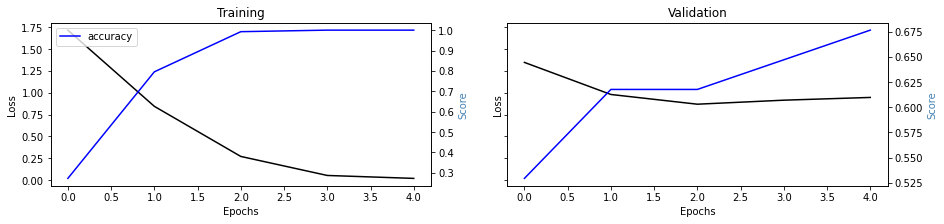


--------------------------------------------------------------------
Iteração: 1 Fold: 7 Accuracy: 0.8095238095238095, Mean Accuracy: 0.6904761904761905

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 105ms/step - loss: 1.7587 - accuracy: 0.2979 - val_loss: 1.4729 - val_accuracy: 0.4118
Epoch 2/5
17/17 [==============================] - 1s 37ms/step - loss: 0.7427 - accuracy: 0.8320 - val_loss: 1.3353 - val_accuracy: 0.4706
Epoch 3/5
17/17 [==============================] - 1s 39ms/step - loss: 0.1816 - accuracy: 1.0000 - val_loss: 1.4097 - val_accuracy: 0.5588
Epoch 4/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0395 - accuracy: 1.0000 - val_loss: 1.5461 - val_accuracy: 0.5588
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 1.7137 - val_accuracy: 0.5294


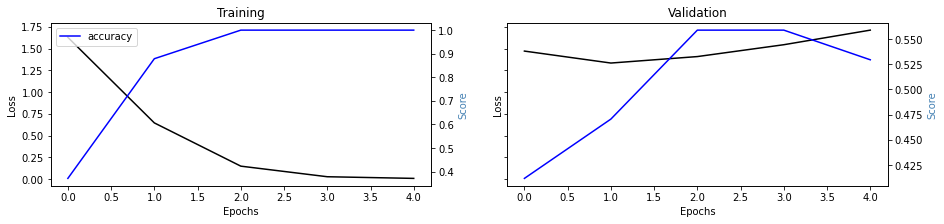


--------------------------------------------------------------------
Iteração: 1 Fold: 8 Accuracy: 0.7380952380952381, Mean Accuracy: 0.6964285714285714

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 104ms/step - loss: 1.8635 - accuracy: 0.2483 - val_loss: 1.1647 - val_accuracy: 0.7059
Epoch 2/5
17/17 [==============================] - 1s 38ms/step - loss: 0.9374 - accuracy: 0.8082 - val_loss: 0.7720 - val_accuracy: 0.7059
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.2844 - accuracy: 0.9826 - val_loss: 0.6291 - val_accuracy: 0.7941
Epoch 4/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0680 - accuracy: 1.0000 - val_loss: 0.6516 - val_accuracy: 0.7941
Epoch 5/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.6689 - val_accuracy: 0.7941


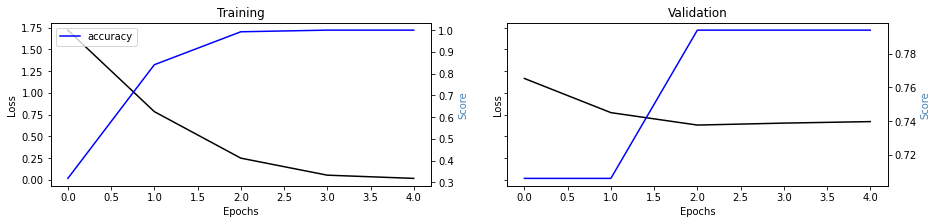


--------------------------------------------------------------------
Iteração: 1 Fold: 9 Accuracy: 0.6904761904761905, Mean Accuracy: 0.6957671957671958

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 107ms/step - loss: 1.8219 - accuracy: 0.3215 - val_loss: 1.1663 - val_accuracy: 0.6471
Epoch 2/5
17/17 [==============================] - 1s 37ms/step - loss: 0.8545 - accuracy: 0.8704 - val_loss: 0.9277 - val_accuracy: 0.6471
Epoch 3/5
17/17 [==============================] - 1s 37ms/step - loss: 0.2546 - accuracy: 0.9769 - val_loss: 0.9800 - val_accuracy: 0.6471
Epoch 4/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0615 - accuracy: 0.9960 - val_loss: 1.2932 - val_accuracy: 0.6176
Epoch 5/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0349 - accuracy: 1.0000 - val_loss: 1.2662 - val_accuracy: 0.6176


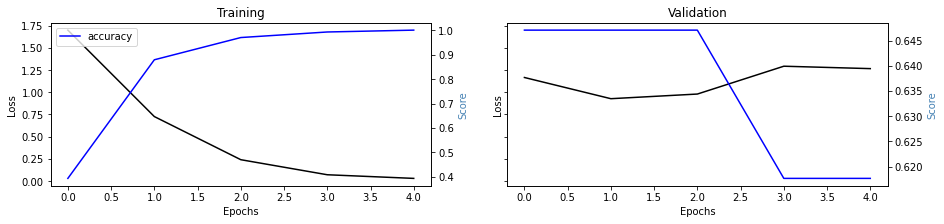


--------------------------------------------------------------------
Iteração: 1 Fold: 10 Accuracy: 0.6428571428571429, Mean Accuracy: 0.6904761904761905

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 104ms/step - loss: 1.7929 - accuracy: 0.3352 - val_loss: 1.3852 - val_accuracy: 0.4412
Epoch 2/5
17/17 [==============================] - 1s 36ms/step - loss: 0.7010 - accuracy: 0.8552 - val_loss: 1.2033 - val_accuracy: 0.5294
Epoch 3/5
17/17 [==============================] - 1s 36ms/step - loss: 0.2578 - accuracy: 0.9847 - val_loss: 1.2303 - val_accuracy: 0.5588
Epoch 4/5
17/17 [==============================] - 1s 37ms/step - loss: 0.1095 - accuracy: 0.9947 - val_loss: 1.7160 - val_accuracy: 0.5000
Epoch 5/5
17/17 [==============================] - 1s 36ms/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 1.7822 - val_accuracy: 0.5000


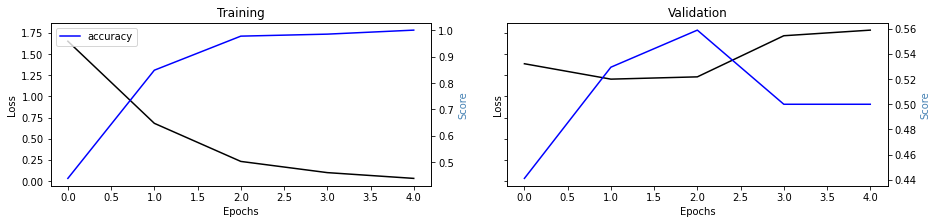


--------------------------------------------------------------------
Iteração: 2 Fold: 1 Accuracy: 0.6666666666666666, Mean Accuracy: 0.6666666666666666

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 8s 105ms/step - loss: 1.7842 - accuracy: 0.3207 - val_loss: 1.3397 - val_accuracy: 0.5294
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.8139 - accuracy: 0.7729 - val_loss: 0.8483 - val_accuracy: 0.7353
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.2505 - accuracy: 0.9766 - val_loss: 0.8018 - val_accuracy: 0.7353
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0646 - accuracy: 0.9927 - val_loss: 0.7716 - val_accuracy: 0.7647
Epoch 5/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.7896 - val_accuracy: 0.7647


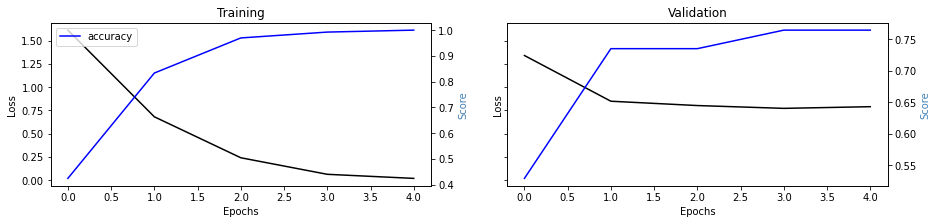


--------------------------------------------------------------------
Iteração: 2 Fold: 2 Accuracy: 0.6190476190476191, Mean Accuracy: 0.6428571428571428

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 108ms/step - loss: 1.7153 - accuracy: 0.4126 - val_loss: 1.4528 - val_accuracy: 0.4706
Epoch 2/5
17/17 [==============================] - 1s 38ms/step - loss: 0.7863 - accuracy: 0.8916 - val_loss: 1.2453 - val_accuracy: 0.5882
Epoch 3/5
17/17 [==============================] - 1s 37ms/step - loss: 0.2551 - accuracy: 0.9813 - val_loss: 1.3104 - val_accuracy: 0.5588
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0547 - accuracy: 0.9972 - val_loss: 1.4968 - val_accuracy: 0.5000
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 1.5208 - val_accuracy: 0.5882


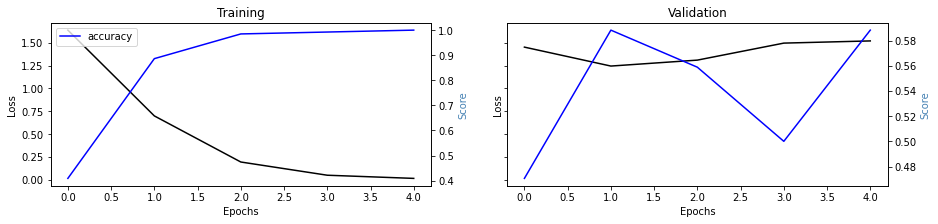


--------------------------------------------------------------------
Iteração: 2 Fold: 3 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7063492063492064

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 105ms/step - loss: 1.7338 - accuracy: 0.3287 - val_loss: 1.2325 - val_accuracy: 0.6471
Epoch 2/5
17/17 [==============================] - 1s 37ms/step - loss: 0.8423 - accuracy: 0.7817 - val_loss: 0.9811 - val_accuracy: 0.6471
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.2764 - accuracy: 0.9612 - val_loss: 0.9194 - val_accuracy: 0.6471
Epoch 4/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0594 - accuracy: 1.0000 - val_loss: 1.0366 - val_accuracy: 0.6765
Epoch 5/5
17/17 [==============================] - 1s 37ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 1.1843 - val_accuracy: 0.7059


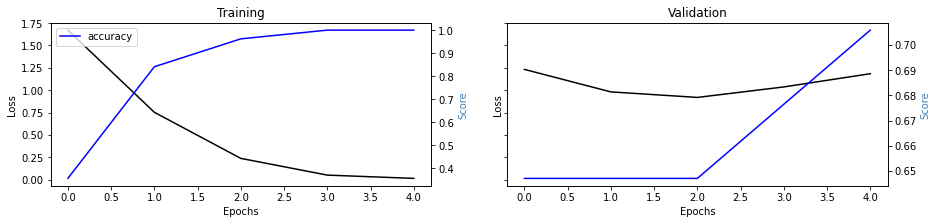


--------------------------------------------------------------------
Iteração: 2 Fold: 4 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7142857142857143

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 106ms/step - loss: 1.8067 - accuracy: 0.2886 - val_loss: 1.4067 - val_accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - 1s 37ms/step - loss: 0.7450 - accuracy: 0.8555 - val_loss: 1.1590 - val_accuracy: 0.5294
Epoch 3/5
17/17 [==============================] - 1s 37ms/step - loss: 0.2627 - accuracy: 0.9854 - val_loss: 1.1537 - val_accuracy: 0.6176
Epoch 4/5
17/17 [==============================] - 1s 36ms/step - loss: 0.0536 - accuracy: 1.0000 - val_loss: 1.2733 - val_accuracy: 0.5588
Epoch 5/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 1.2559 - val_accuracy: 0.6471


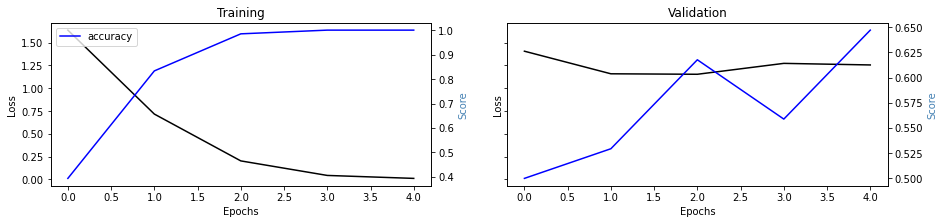


--------------------------------------------------------------------
Iteração: 2 Fold: 5 Accuracy: 0.6666666666666666, Mean Accuracy: 0.7047619047619047

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 8s 109ms/step - loss: 1.7439 - accuracy: 0.4077 - val_loss: 1.3411 - val_accuracy: 0.5294
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.7162 - accuracy: 0.9229 - val_loss: 1.0804 - val_accuracy: 0.5882
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.2210 - accuracy: 0.9784 - val_loss: 1.1393 - val_accuracy: 0.5588
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0708 - accuracy: 1.0000 - val_loss: 1.1056 - val_accuracy: 0.6176
Epoch 5/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 1.4131 - val_accuracy: 0.6765


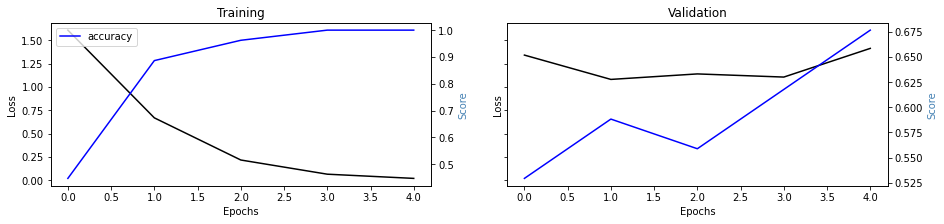


--------------------------------------------------------------------
Iteração: 2 Fold: 6 Accuracy: 0.6428571428571429, Mean Accuracy: 0.6944444444444445

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 108ms/step - loss: 1.7694 - accuracy: 0.3104 - val_loss: 1.3136 - val_accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.8642 - accuracy: 0.8075 - val_loss: 0.9635 - val_accuracy: 0.7353
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.3283 - accuracy: 0.9879 - val_loss: 0.9394 - val_accuracy: 0.6471
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0758 - accuracy: 0.9953 - val_loss: 0.9026 - val_accuracy: 0.6765
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0553 - accuracy: 0.9937 - val_loss: 1.1077 - val_accuracy: 0.6176


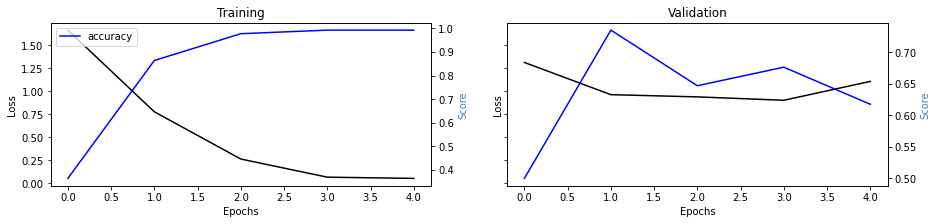


--------------------------------------------------------------------
Iteração: 2 Fold: 7 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7040816326530612

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 108ms/step - loss: 1.8167 - accuracy: 0.2616 - val_loss: 1.5444 - val_accuracy: 0.4412
Epoch 2/5
17/17 [==============================] - 1s 38ms/step - loss: 0.8222 - accuracy: 0.7761 - val_loss: 1.2438 - val_accuracy: 0.5588
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.2523 - accuracy: 0.9836 - val_loss: 1.4950 - val_accuracy: 0.5588
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0402 - accuracy: 1.0000 - val_loss: 1.7144 - val_accuracy: 0.5588
Epoch 5/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 1.9294 - val_accuracy: 0.5294


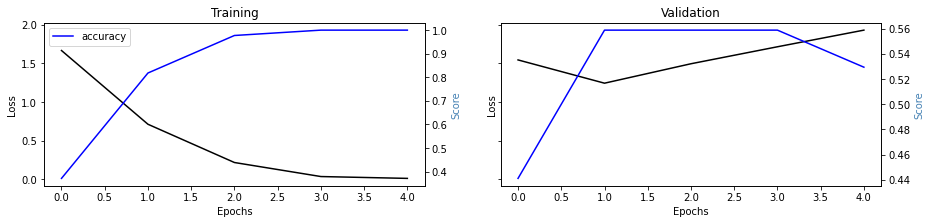


--------------------------------------------------------------------
Iteração: 2 Fold: 8 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7113095238095238

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 106ms/step - loss: 1.8063 - accuracy: 0.2878 - val_loss: 1.1759 - val_accuracy: 0.7059
Epoch 2/5
17/17 [==============================] - 1s 38ms/step - loss: 0.8687 - accuracy: 0.8193 - val_loss: 0.7602 - val_accuracy: 0.7647
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.3024 - accuracy: 0.9631 - val_loss: 0.7087 - val_accuracy: 0.7059
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0811 - accuracy: 0.9821 - val_loss: 0.5978 - val_accuracy: 0.7353
Epoch 5/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0221 - accuracy: 1.0000 - val_loss: 0.5634 - val_accuracy: 0.7647


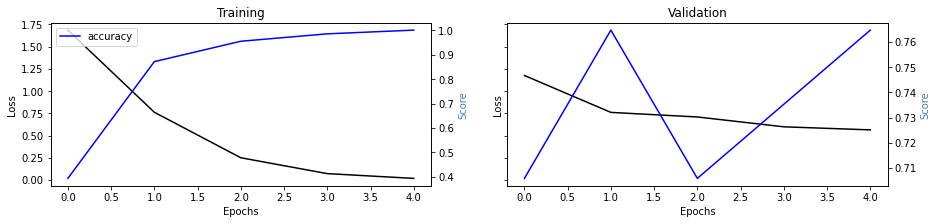


--------------------------------------------------------------------
Iteração: 2 Fold: 9 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7116402116402116

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 8s 223ms/step - loss: 1.8195 - accuracy: 0.2249 - val_loss: 1.2184 - val_accuracy: 0.6176
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.8115 - accuracy: 0.8281 - val_loss: 0.9769 - val_accuracy: 0.7059
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.2363 - accuracy: 0.9793 - val_loss: 0.9013 - val_accuracy: 0.6765
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0537 - accuracy: 1.0000 - val_loss: 0.9311 - val_accuracy: 0.6765
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 1.0563 - val_accuracy: 0.7059


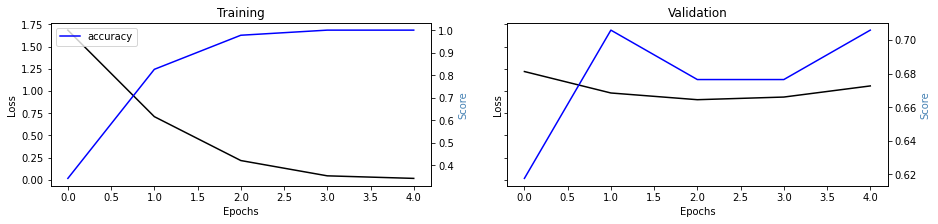


--------------------------------------------------------------------
Iteração: 2 Fold: 10 Accuracy: 0.6904761904761905, Mean Accuracy: 0.7095238095238096

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 107ms/step - loss: 1.8239 - accuracy: 0.2667 - val_loss: 1.3856 - val_accuracy: 0.4706
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.7577 - accuracy: 0.8771 - val_loss: 1.2324 - val_accuracy: 0.5294
Epoch 3/5
17/17 [==============================] - 1s 39ms/step - loss: 0.2639 - accuracy: 0.9902 - val_loss: 1.2614 - val_accuracy: 0.5000
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0563 - accuracy: 0.9983 - val_loss: 1.2516 - val_accuracy: 0.6176
Epoch 5/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 1.2308 - val_accuracy: 0.6176


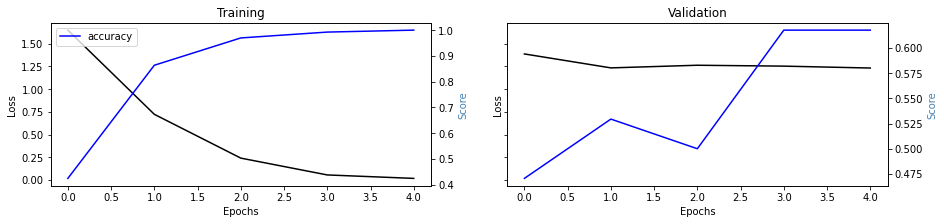


--------------------------------------------------------------------
Iteração: 3 Fold: 1 Accuracy: 0.6666666666666666, Mean Accuracy: 0.6666666666666666

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 106ms/step - loss: 1.7171 - accuracy: 0.3160 - val_loss: 1.3820 - val_accuracy: 0.4706
Epoch 2/5
17/17 [==============================] - 1s 38ms/step - loss: 0.7112 - accuracy: 0.8709 - val_loss: 1.0104 - val_accuracy: 0.6176
Epoch 3/5
17/17 [==============================] - 1s 39ms/step - loss: 0.2944 - accuracy: 0.9520 - val_loss: 0.8000 - val_accuracy: 0.6471
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0515 - accuracy: 1.0000 - val_loss: 0.8991 - val_accuracy: 0.6765
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.0690 - val_accuracy: 0.6471


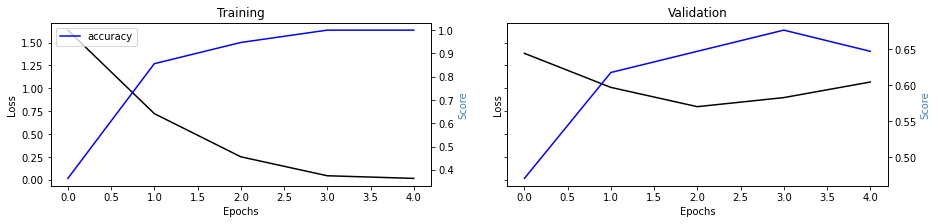


--------------------------------------------------------------------
Iteração: 3 Fold: 2 Accuracy: 0.6190476190476191, Mean Accuracy: 0.6428571428571428

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 107ms/step - loss: 1.8237 - accuracy: 0.2567 - val_loss: 1.3702 - val_accuracy: 0.4706
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.7783 - accuracy: 0.8679 - val_loss: 1.1590 - val_accuracy: 0.5588
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.2830 - accuracy: 0.9561 - val_loss: 1.2323 - val_accuracy: 0.6176
Epoch 4/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0591 - accuracy: 1.0000 - val_loss: 1.4185 - val_accuracy: 0.5000
Epoch 5/5
17/17 [==============================] - 1s 40ms/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 1.2882 - val_accuracy: 0.5882


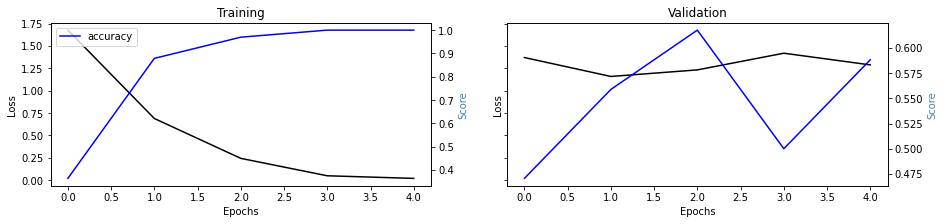


--------------------------------------------------------------------
Iteração: 3 Fold: 3 Accuracy: 0.7380952380952381, Mean Accuracy: 0.6746031746031745

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 108ms/step - loss: 1.8220 - accuracy: 0.2289 - val_loss: 1.4245 - val_accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.8079 - accuracy: 0.9049 - val_loss: 1.0955 - val_accuracy: 0.5000
Epoch 3/5
17/17 [==============================] - 1s 39ms/step - loss: 0.2447 - accuracy: 0.9938 - val_loss: 1.0658 - val_accuracy: 0.5588
Epoch 4/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0455 - accuracy: 1.0000 - val_loss: 1.2744 - val_accuracy: 0.6176
Epoch 5/5
17/17 [==============================] - 1s 40ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 1.3914 - val_accuracy: 0.5882


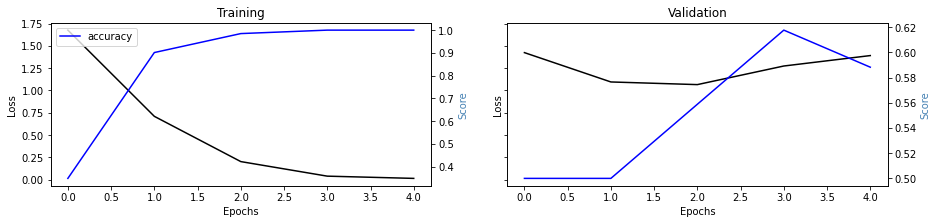


--------------------------------------------------------------------
Iteração: 3 Fold: 4 Accuracy: 0.7142857142857143, Mean Accuracy: 0.6845238095238095

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 8s 108ms/step - loss: 1.7787 - accuracy: 0.2667 - val_loss: 1.3981 - val_accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.7745 - accuracy: 0.8548 - val_loss: 1.1209 - val_accuracy: 0.6176
Epoch 3/5
17/17 [==============================] - 1s 39ms/step - loss: 0.1952 - accuracy: 0.9960 - val_loss: 1.2147 - val_accuracy: 0.5588
Epoch 4/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0397 - accuracy: 1.0000 - val_loss: 1.2886 - val_accuracy: 0.6176
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 1.3361 - val_accuracy: 0.6765


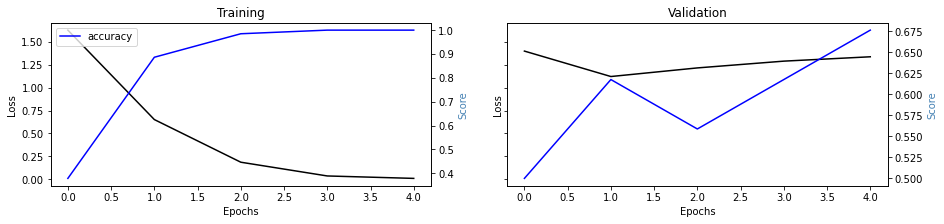


--------------------------------------------------------------------
Iteração: 3 Fold: 5 Accuracy: 0.7380952380952381, Mean Accuracy: 0.6952380952380952

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 108ms/step - loss: 1.7418 - accuracy: 0.3631 - val_loss: 1.3706 - val_accuracy: 0.5294
Epoch 2/5
17/17 [==============================] - 1s 40ms/step - loss: 0.8593 - accuracy: 0.8250 - val_loss: 1.1371 - val_accuracy: 0.6765
Epoch 3/5
17/17 [==============================] - 1s 40ms/step - loss: 0.2870 - accuracy: 0.9927 - val_loss: 1.0662 - val_accuracy: 0.6471
Epoch 4/5
17/17 [==============================] - 1s 40ms/step - loss: 0.0422 - accuracy: 1.0000 - val_loss: 1.1334 - val_accuracy: 0.6471
Epoch 5/5
17/17 [==============================] - 1s 41ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 1.1837 - val_accuracy: 0.6765


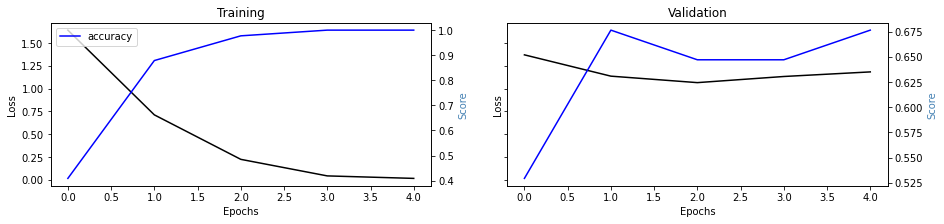


--------------------------------------------------------------------
Iteração: 3 Fold: 6 Accuracy: 0.6190476190476191, Mean Accuracy: 0.6825396825396824

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 110ms/step - loss: 1.8295 - accuracy: 0.2543 - val_loss: 1.2276 - val_accuracy: 0.6765
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.8746 - accuracy: 0.8315 - val_loss: 0.8532 - val_accuracy: 0.7059
Epoch 3/5
17/17 [==============================] - 1s 39ms/step - loss: 0.2745 - accuracy: 0.9655 - val_loss: 0.7139 - val_accuracy: 0.6765
Epoch 4/5
17/17 [==============================] - 1s 41ms/step - loss: 0.0759 - accuracy: 1.0000 - val_loss: 0.9431 - val_accuracy: 0.6471
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.9888 - val_accuracy: 0.6765


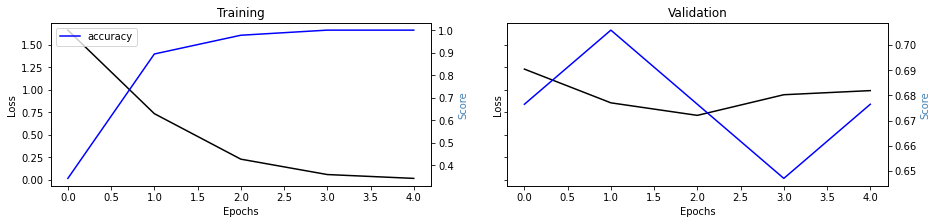


--------------------------------------------------------------------
Iteração: 3 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.6972789115646257

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 107ms/step - loss: 1.7881 - accuracy: 0.3407 - val_loss: 1.5497 - val_accuracy: 0.4412
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.8569 - accuracy: 0.8201 - val_loss: 1.3566 - val_accuracy: 0.5000
Epoch 3/5
17/17 [==============================] - 1s 40ms/step - loss: 0.2784 - accuracy: 0.9673 - val_loss: 1.4275 - val_accuracy: 0.5000
Epoch 4/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0614 - accuracy: 1.0000 - val_loss: 1.7985 - val_accuracy: 0.4412
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 1.8076 - val_accuracy: 0.4706


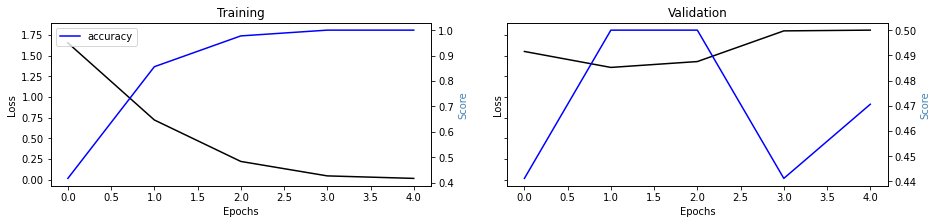


--------------------------------------------------------------------
Iteração: 3 Fold: 8 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7113095238095237

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 8s 109ms/step - loss: 1.7877 - accuracy: 0.3012 - val_loss: 1.1486 - val_accuracy: 0.7353
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.8290 - accuracy: 0.7939 - val_loss: 0.8991 - val_accuracy: 0.7353
Epoch 3/5
17/17 [==============================] - 1s 38ms/step - loss: 0.2869 - accuracy: 0.9713 - val_loss: 0.7039 - val_accuracy: 0.7941
Epoch 4/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0911 - accuracy: 0.9927 - val_loss: 0.8396 - val_accuracy: 0.6765
Epoch 5/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.8365 - val_accuracy: 0.7353


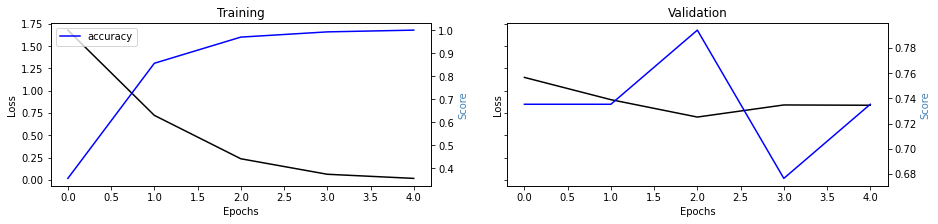


--------------------------------------------------------------------
Iteração: 3 Fold: 9 Accuracy: 0.6666666666666666, Mean Accuracy: 0.7063492063492063

--------------------------------------------------------------------
Epoch 1/5
17/17 [==============================] - 6s 108ms/step - loss: 1.7999 - accuracy: 0.3931 - val_loss: 1.1999 - val_accuracy: 0.6765
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.7436 - accuracy: 0.9013 - val_loss: 0.9482 - val_accuracy: 0.7059
Epoch 3/5
17/17 [==============================] - 1s 39ms/step - loss: 0.2277 - accuracy: 0.9915 - val_loss: 0.9814 - val_accuracy: 0.7059
Epoch 4/5
17/17 [==============================] - 1s 38ms/step - loss: 0.0457 - accuracy: 1.0000 - val_loss: 1.0599 - val_accuracy: 0.6765
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0257 - accuracy: 0.9915 - val_loss: 1.1368 - val_accuracy: 0.6765


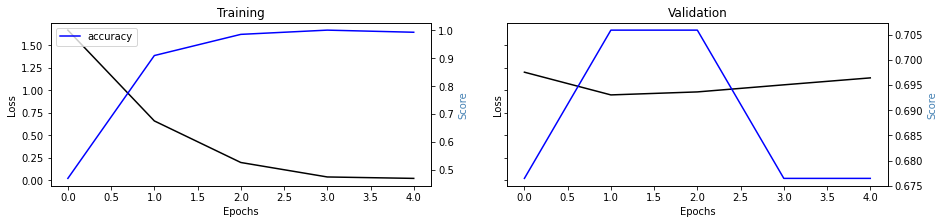


--------------------------------------------------------------------
Iteração: 3 Fold: 10 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7071428571428571

--------------------------------------------------------------------


In [100]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(3):

    accrs = []
    fold=0
#     conf_matrix_list_of_arrays = []

    k=10
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold +=1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model, predicted_prob, predicted = fit_bert_classif(X_train, y_train, X_test, encode_y=True, 
                                                            model=None, epochs=5, batch_size=8)
        # Validade Test Set
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays.append(conf_matrix)
        #
        accrs.append(accr)

        print('\n--------------------------------------------------------------------')
        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
        print('\n--------------------------------------------------------------------')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

In [103]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 3 | CV: 10 | Média Final: 0.7023809523809522


### Evaluate

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       1.0	       0.5	      0.67	       0.7	      0.75
List of Contributors	       1.0	       0.8	      0.89	      0.88	       0.9
Setup Files         	      0.71	      0.83	      0.77	      0.72	      0.88
Requirement Document	       1.0	       0.5	      0.67	       0.7	      0.75
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	      0.62	      0.71	      0.67	      0.58	      0.81
Release Notes       	      0.62	      0.71	      0.67	      0.58	      0.81

Micro Average       	      0.78	      0.78	      0.78	      0.72	      0.87
Macro Average       	      0.85	      0.72	      0.76	      0.74	      0.84


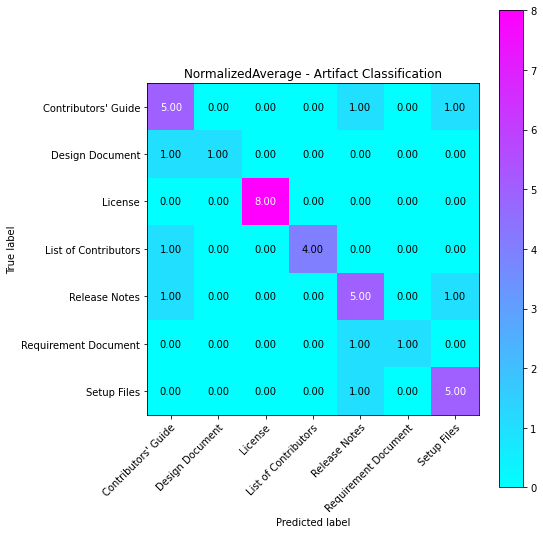

In [104]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## Word2Vec with Conventional Machine Learning

### Create the Feature Vector With Word2Vec

In [ ]:
class Word2VecVectorizer:
  def __init__(self, word_vect):
    print("Loading in word vectors...")
    self.word_vectors = word_vect
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

### Vectorization

In [ ]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(word_vect)
# Get the sentence embeddings for the train and test datasets
X = corpus

y = df["Label"].values

# Use for mNB
from sklearn.preprocessing import MinMaxScaler, normalize
def normalizer(X):
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    normalized_X = normalize(scaled_X, norm='max', axis=0, copy=True)
    return(normalized_X)

Loading in word vectors...
Finished loading in word vectors


In [ ]:
def encode_y_train(y_train):
# from sklearn.preprocessing import LabelEncoder
    vectorizer = LabelEncoder()
    y_train = vectorizer.fit_transform(y_train)
    return y_train

### Classifier

### Cross Validation and Fitting the Model

In [ ]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y))}

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    fold=0

    k=10
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold += 1

        X_train = vectorizer.fit_transform(X_train)
        # X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        # X_test = normalizer(X_test) # Use for mNB
        y_train=encode_y_train(y_train)

        # train classifier
        model = dt.fit(X_train, y_train)
        
        # test
        predicted_prob = model.predict_proba(X_test)
        predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
                predicted_prob]
    #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accr = metrics.accuracy_score(y_test, predicted)
        accrs.append(accr)

        print('\n--------------------------------------------------------------------')
        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
        print('\n--------------------------------------------------------------------')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Numer of samples with no words found: 0 / 166
Numer of samples with no words found: 0 / 42

--------------------------------------------------------------------
Iteração: 1 Fold: 1 Accuracy: 0.6428571428571429, Mean Accuracy: 0.6428571428571429

--------------------------------------------------------------------
Numer of samples with no words found: 0 / 166
Numer of samples with no words found: 0 / 42

--------------------------------------------------------------------
Iteração: 1 Fold: 2 Accuracy: 0.6190476190476191, Mean Accuracy: 0.6309523809523809

--------------------------------------------------------------------
Numer of samples with no words found: 0 / 166
Numer of samples with no words found: 0 / 42

--------------------------------------------------------------------
Iteração: 1 Fold: 3 Accuracy: 0.6904761904761905, Mean Accuracy: 0.6507936507936508

--------------------------------------------------------------------
Numer of samples with no words found: 0 / 166
Numer of 

In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.5399999999999999


### Evaluate

#### Plot Metrics Resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	      0.33	       0.5	       0.4	      0.37	      0.72
List of Contributors	       0.4	       0.4	       0.4	      0.32	      0.66
Setup Files         	      0.57	      0.67	      0.62	      0.55	      0.79
Requirement Document	      0.25	      0.33	      0.29	      0.22	      0.63
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	       0.5	       0.5	       0.5	      0.38	      0.69
Release Notes       	      0.57	       0.4	      0.47	      0.35	      0.65

Micro Average       	      0.56	      0.56	      0.56	      0.55	      0.74
Macro Average       	      0.52	      0.54	      0.52	      0.45	      0.73


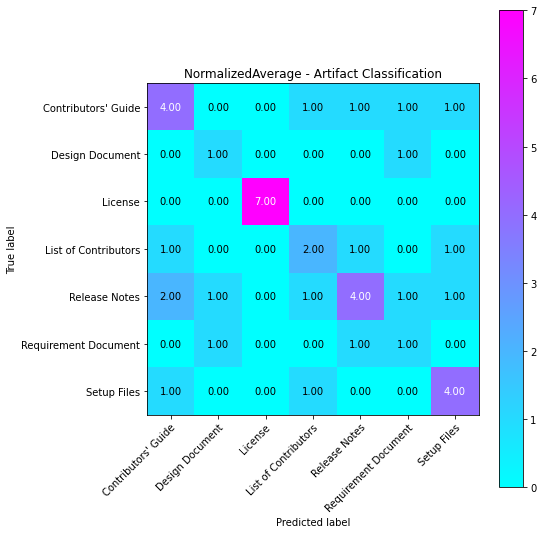

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

### Voting Classifier

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    kfolds=10
    fold = 0
    sss = StratifiedShuffleSplit(n_splits=kfolds, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold +=1

        X_train = vectorizer.fit_transform(X_train)
        X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        X_test = normalizer(X_test) # Use for mNB
        
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        
        model = VotingClassifier(estimators=[
            ('svm', clf1),('rf', clf2), ('mnb', clf3), ('tree', clf4)], voting='hard',weights=[1,1,2,1])
        model = model.fit(X_train, y_train)
        
        predicted = model.predict(X_test)
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
        #    
        accrs.append(accr)

        print('\n--------------------------------------------------------------------')
        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
        print('\n--------------------------------------------------------------------')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Numer of samples with no words found: 0 / 166
Numer of samples with no words found: 0 / 42

--------------------------------------------------------------------
Iteração: 1 Fold: 1 Accuracy: 0.5952380952380952, Mean Accuracy: 0.5952380952380952

--------------------------------------------------------------------
Numer of samples with no words found: 0 / 166
Numer of samples with no words found: 0 / 42

--------------------------------------------------------------------
Iteração: 1 Fold: 2 Accuracy: 0.40476190476190477, Mean Accuracy: 0.5

--------------------------------------------------------------------
Numer of samples with no words found: 0 / 166
Numer of samples with no words found: 0 / 42

--------------------------------------------------------------------
Iteração: 1 Fold: 3 Accuracy: 0.6904761904761905, Mean Accuracy: 0.5634920634920635

--------------------------------------------------------------------
Numer of samples with no words found: 0 / 166
Numer of samples with n

In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.5809523809523809


### Evaluate

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       0.5	      0.67	      0.57	      0.54	       0.8
List of Contributors	       1.0	       0.8	      0.89	      0.88	       0.9
Setup Files         	      0.35	       1.0	      0.52	      0.48	      0.83
Requirement Document	       1.0	      0.33	       0.5	      0.56	      0.67
License             	       1.0	      0.86	      0.92	      0.91	      0.93
Contributors' Guide 	      0.67	      0.33	      0.44	      0.41	      0.65
Release Notes       	       1.0	      0.38	      0.55	      0.57	      0.69

Micro Average       	      0.63	      0.63	      0.63	      0.48	      0.78
Macro Average       	      0.79	      0.62	      0.63	      0.62	      0.78


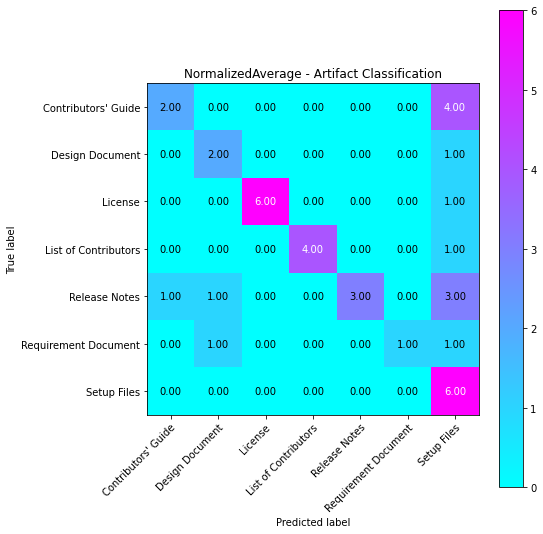

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))